In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [68]:
# ===== Функции для генерации сигналов =====
def generate_signals(a, t1, t2, b, c, d, T, dt):
    """
    Генерирует временной вектор, исходный сигнал g(t) и зашумлённый сигнал u(t).
    Здесь u(t) = g(t) + b*ξ(t) + c*sin(d*t), где ξ(t) – белый шум (U[-1,1]).
    """
    t = np.arange(-T / 2, T / 2, dt)
    g = np.zeros_like(t)
    g[(t >= t1) & (t <= t2)] = a

    # Генерация белого шума (равномерное распределение на [-1,1])
    xi = 2 * np.random.rand(len(t)) - 1
    u = g + b * xi + c * np.sin(d * t)
    return t, g, u

def read_audio(filename):
    fs, y = wavfile.read(filename)
    return fs, y

In [69]:
# ===== Функции для работы с Фурье-преобразованием =====
def compute_fft(u, dt):
    """
    Вычисляет центрированное Фурье-преобразование сигнала u(t) и вектор частот.
    """
    N = len(u)
    U = np.fft.fftshift(np.fft.fft(u))
    # Ширина спектра и шаг по частоте:
    V = 1 / dt
    dv = 1 / (N * dt)
    f = np.linspace(-V / 2, V / 2 - dv, N)
    return f, U


def inverse_fft(U):
    """
    Выполняет обратное Фурье-преобразование от центрированного спектра U.
    """
    u_rec = np.fft.ifft(np.fft.ifftshift(U))
    return np.real(u_rec)

In [70]:
# ===== Функции для построения графиков =====
def plot_time_signals(t, signals, labels, title, freq_lim=None, colors=None, path=None):
    plt.figure(figsize=(10, 4))
    for n, (signal, label) in enumerate(zip(signals, labels)):
        if colors:
            plt.plot(t, signal, colors[n], label=label)
        else:
            plt.plot(t, signal, label=label)
        # plt.plot(t, signal, label=label)
    if freq_lim is not None:
        plt.xlim([-freq_lim, freq_lim])
    plt.xlabel('Время')
    plt.ylabel('Амплитуда')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()


def plot_spectra(f, spectra, labels, title, freq_lim=None, colors=None, path=None):
    """
    Строит график спектров сигналов (модули Фурье-образов). Если задан freq_lim, выводит ось частот в диапазоне [-freq_lim, freq_lim].
    """
    plt.figure(figsize=(10, 4))
    for n, (spec, label) in enumerate(zip(spectra, labels)):
        if colors:
            plt.plot(f, spec, colors[n], label=label)
        else:
            plt.plot(f, spec, label=label)
    if freq_lim is not None:
        plt.xlim([-freq_lim, freq_lim])
    plt.xlabel('Частота')
    plt.ylabel('Модуль')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()

In [71]:
# ===== Функция фильтрации нижних частот =====
def low_pass_filter(U, f, cutoff):
    """
    Применяет фильтр нижних частот: обнуляет спектральные компоненты для |f| > cutoff.
    """
    mask = np.abs(f) <= cutoff  # оставляем частоты от -cutoff до cutoff
    return U * mask


# ===== Функция обработки сигнала для заданных параметров =====
def process_signal(a, t1, t2, b, c, d, T, dt, cutoff):
    """
    Генерирует сигналы, вычисляет Фурье-преобразование, применяет фильтр нижних частот и восстанавливает сигнал.
    Возвращает:
      t, g, u, u_filtered, f, U_spec, U_filtered_spec, G_spec
    """
    t, g, u = generate_signals(a, t1, t2, b, c, d, T, dt)
    f, U = compute_fft(u, dt)
    U_filtered = low_pass_filter(U, f, cutoff)
    u_filtered = inverse_fft(U_filtered)

    N = len(t)
    # Вычисляем модули спектров, нормированные по числу точек:
    G_spec = np.abs(np.fft.fftshift(np.fft.fft(g))) / N
    U_spec = np.abs(U) / N
    U_filtered_spec = np.abs(U_filtered) / N

    return t, g, u, u_filtered, f, G_spec, U_spec, U_filtered_spec


# ===== Функция Notch‑фильтра =====
def notch_filter(U, f, f0, notch_width):
    """
    Применяет notch-фильтр, обнуляя спектральные компоненты в окрестности частоты f0:
    обнуляются компоненты в диапазоне [f0 - notch_width, f0 + notch_width] и для отрицательных частот [-f0 - notch_width, -f0 + notch_width].
    """
    mask = np.ones_like(f, dtype=bool)
    mask[np.logical_and(f >= f0 - notch_width, f <= f0 + notch_width)] = False
    mask[np.logical_and(f >= -f0 - notch_width, f <= -f0 + notch_width)] = False
    return U * mask


# ===== Функция фильтрации высоких частот =====
def high_pass_filter(U, f, cutoff):
    """
    Применяет фильтр высоких частот: обнуляет спектральные компоненты для |f| < cutoff.
    """
    mask = np.abs(f) >= cutoff
    return U * mask


# ===== Функция band-pass фильтра =====
def bandpass_filter(U, f, f_low, f_high):
    mask = (np.abs(f) >= f_low) & (np.abs(f) <= f_high)
    return U * mask

In [72]:
def task1_0(a, t1, t2, b_values, c=0.0, d=20.0, T=10.0, dt=0.01):
    """
    Генерирует сигнал, вычисляет Фурье-преобразование и строит графики временных сигналов и спектров.
    """
    t, g, _ = generate_signals(a, t1, t2, b_values[0], c, d, T, dt)
    plot_time_signals(t, [g], ['g(t)'], '')
    for b in b_values:
        t, g, u = generate_signals(a, t1, t2, b, c, d, T, dt)
        f, U = compute_fft(u, dt)
        N = len(t)
        U_spec = np.abs(U) / N

        plot_time_signals(t, [u], ['u(t)'], '', path=f"src/time_{b}.png")
        plot_spectra(f, [U_spec], ['Спектр u(t)'], '', freq_lim=10, path=f"src/spec_{b}.png")

In [73]:
def task1_1(a, t1, t2, b_values, cutoff_values, c=0.0, d=20.0, T=10.0, dt=0.01, cutoff=5.0):
    """
    Реализует задание 1.1: генерирует сигнал, вычисляет Фурье-преобразование,
    фильтрует сигнал фильтром нижних частот и строит графики временных сигналов и спектров.
    """
    for b in b_values:
        for cutoff in cutoff_values:
            t, g, u, u_filtered, f, G_spec, U_spec, U_filtered_spec = process_signal(a, t1, t2, b, c, d, T, dt, cutoff)
            title_time = f"Временные сигналы (b={b}, ν₀={cutoff})"
            print(title_time)
            plot_time_signals(t, [g, u, u_filtered], ['g(t)', 'u(t)', 'Фильтрованный'], '',
                              path=f"src/lpf/time_{b}_{cutoff}.png")

            title_spec = f"Спектры сигналов (b={b}, ν₀={cutoff})"
            print(title_spec)
            plot_spectra(f, [G_spec, U_spec, U_filtered_spec], ['Спектр g(t)', 'Спектр u(t)', 'Спектр фильтрованного'],
                         '', freq_lim=7, path=f"src/lpf/spec_{b}_{cutoff}.png")

In [74]:
def task1_2(a, t1, t2, b_values, c_values, d_values, cutoff_values, notch_width, T, dt, freq_lim=None):
    """
    Реализует задание 1.2 с использованием совмещенного фильтра:
    сначала применяется фильтр нижних частот с заданым срезом (cutoff),
    затем notch‑фильтр для удаления гармоники.

    Для каждой комбинации параметров (b, c, d) и вариантов cutoff, notch_width
    строятся графики временных сигналов и их спектров.
    """
    for b in b_values:
        for c in c_values:
            for d in d_values:
                for cutoff in cutoff_values:
                    t, g, u = generate_signals(a, t1, t2, b, c, d, T, dt)
                    f, U = compute_fft(u, dt)
                    U_lp = low_pass_filter(U, f, cutoff)
                    U_filtered = notch_filter(U_lp, f, d / (2 * np.pi), notch_width)
                    u_filtered = inverse_fft(U_filtered)

                    # Нормировка спектров для визуализации
                    N = len(t)
                    G_spec = np.abs(np.fft.fftshift(np.fft.fft(g))) / N
                    U_spec = np.abs(U) / N
                    U_filtered_spec = np.abs(U_filtered) / N

                    config_title = f"b={b}, c={c}, d={d}, ν₀={cutoff}, notch_width={notch_width}"
                    print("Конфигурация:", config_title)

                    plot_time_signals(t, [u, u_filtered, g], ['u(t)', 'Фильтрованный', 'g(t)'], '', freq_lim=freq_lim,
                                      colors=['orange', 'g', 'lightblue'],
                                      path=f"src/npf/time_{b}_{c}_{d}_{cutoff}.png")

                    spec_title = "Спектры: " + config_title
                    plot_spectra(f, [G_spec, U_spec, U_filtered_spec],
                                 ['Спектр g(t)', 'Спектр u(t)', 'Спектр фильтрованного'], '', freq_lim=7,
                                 path=f"src/npf/spec_{b}_{c}_{d}_{cutoff}.png")

In [75]:
def task1_3(a, t1, t2, b_values, c_values, d_values, cutoff_values, T=10.0, dt=0.01, freq_lim=None):
    """
    Задание 1.3: Убираем низкие частоты (High-Pass Filter).
    Перебираются параметры b, c, d, а также cutoff.
    """
    for b in b_values:
        for c in c_values:
            for d in d_values:
                for cutoff in cutoff_values:
                    t, g, u = generate_signals(a, t1, t2, b, c, d, T, dt)
                    f, U = compute_fft(u, dt)
                    U_filtered = high_pass_filter(U, f, cutoff)
                    u_filtered = inverse_fft(U_filtered)

                    # Нормировка спектров для визуализации
                    N = len(t)
                    G_spec = np.abs(np.fft.fftshift(np.fft.fft(g))) / N
                    U_spec = np.abs(U) / N
                    U_filtered_spec = np.abs(U_filtered) / N

                    # 10) Заголовки и вывод
                    config_str = f"(b={b}, c={c}, d={d}, cutoff={cutoff})"

                    print("Временные сигналы", config_str)
                    plot_time_signals(t, [g, u, u_filtered], labels=['g(t)', 'u(t)', 'Фильтрованный (HPF)'], title='',
                                      path=f"src/hpf/time_{b}_{c}_{d}_{cutoff}.png", freq_lim=freq_lim)

                    print("Спектры сигналов", config_str)
                    plot_spectra(f, [G_spec, U_spec, U_filtered_spec],
                                 labels=['Спектр g(t)', 'Спектр u(t)', 'Спектр HPF-фильтрованного'], title='',
                                 path=f"src/hpf/spec_{b}_{c}_{d}_{cutoff}.png", freq_lim=10)

In [76]:
def task2(filename, f_low, f_high):
    fs, u = read_audio(filename)
    dt = 1.0 / fs
    f, U = compute_fft(u, dt)
    U_filtered = bandpass_filter(U, f, f_low, f_high)
    u_filtered = inverse_fft(U_filtered)

    t = np.linspace(0, len(u)/fs, len(u))
    N = len(t)
    U_spec = np.abs(U) / N
    U_filtered_spec = np.abs(U_filtered) / N

    t = np.linspace(0, len(u)/fs, len(u))
    plot_time_signals(t, [u, u_filtered], ['Оригинал'], '', path=f"src/time_orig_rec.png")
    plot_spectra(f, [U_spec, U_filtered_spec], ['Спектр оригинала'], '', freq_lim=500, path=f"src/spec_orig_rec.png")
    plot_time_signals(t, [u, u_filtered], ['Оригинал', 'Фильтрованный'], '', path=f"src/time_orig_filter_rec.png")
    plot_spectra(f, [U_spec, U_filtered_spec], ['Спектр оригинала', 'Спектр фильтрованного'], '', freq_lim=500, path=f"src/spec_orig_filter_rec.png")

    u_int16 = np.int16(u_filtered/np.max(np.abs(u_filtered)) * 32767)

    wavfile.write("src/filtered.wav", fs, u_int16)

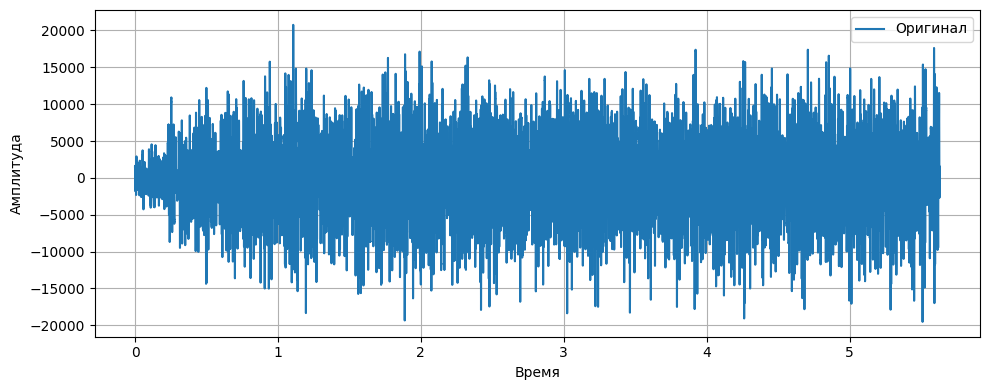

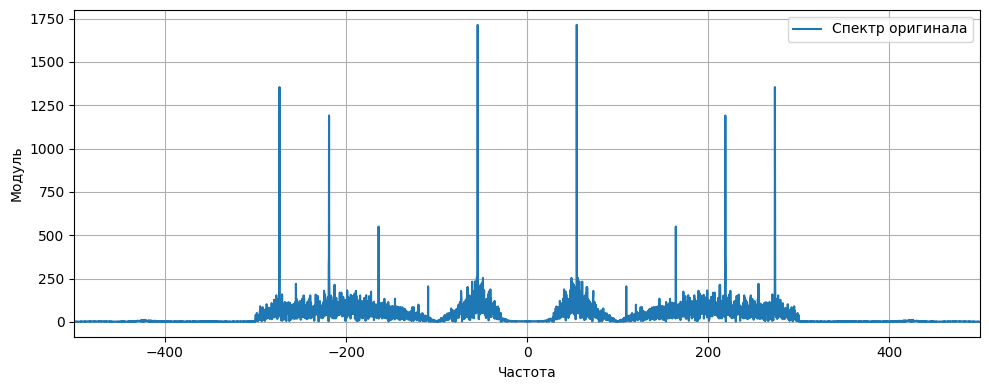

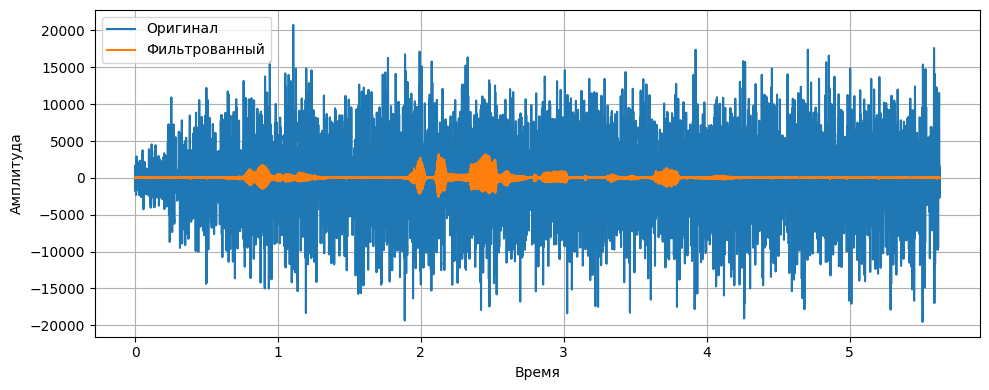

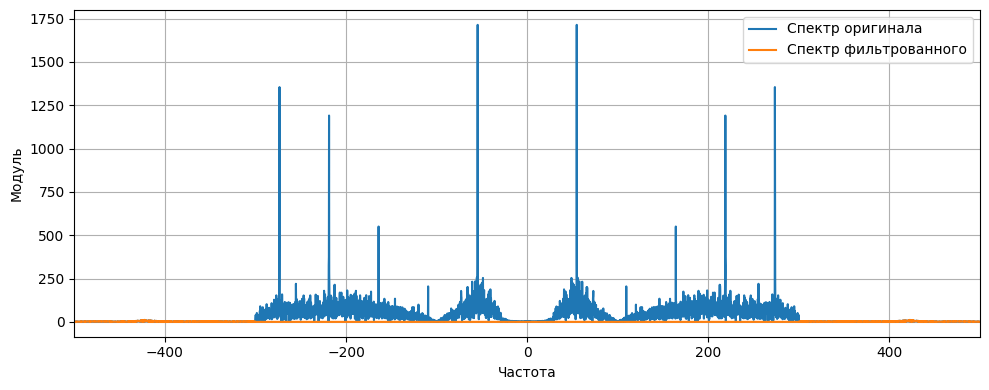

In [77]:
a = 3  # Амплитуда прямоугольного сигнала
t1, t2 = -2, 1  # Интервал, где g(t) = a
T = 40  # Общая длительность временного интервала
dt = 0.001  # Шаг дискретизации
b_values = [0.1, 1.0, 3.0]
cutoff_values = [1.0, 5.0, 10.0]

# task1_0(a, t1, t2, b_values)
# task1_1(a, t1, t2, b_values, cutoff_values)

b_values = [0, 1.0, 2.0]  # уровень белого шума
c_values = [0.5, 1.0]  # амплитуда гармонической составляющей
d_values = [5.0, 10.0]  # частота гармоники
cutoff_values = [4.0, 8.0]  # частота среза для низкочастотного фильтра
notch_width = 0.5  # ширина notch-фильтра

# task1_2(a, t1, t2, b_values, c_values, d_values, cutoff_values, notch_width, T, dt, freq_lim=5)

b_values = [0, 2.0]  # уровень белого шума
c_values = [0.5, 1.0]  # амплитуда гармонической составляющей
d_values = [10.0]  # частота гармоники
cutoff_values = [4.0, 8.0]  # частота среза для низкочастотного фильтра

# task1_3(a, t1, t2, b_values, c_values, d_values, cutoff_values, T, dt, freq_lim=5)

filename = 'src/MUHA.wav'
f_low = 300
f_high = 7000
task2(filename, f_low, f_high)